# 19장 세상에 없는 얼굴 GAN, 오토인코더

## 3. 적대적 신경망 실행하기

### 실습: GAN 모델 만들기

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


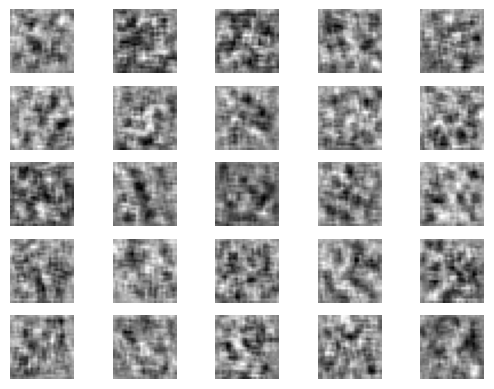

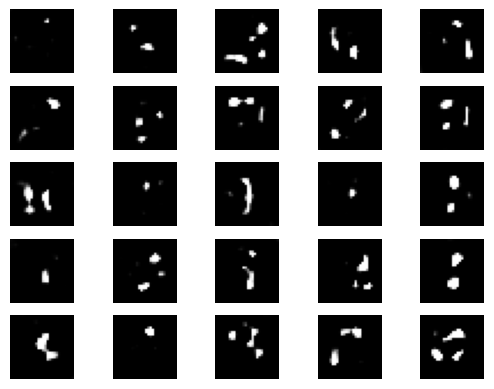

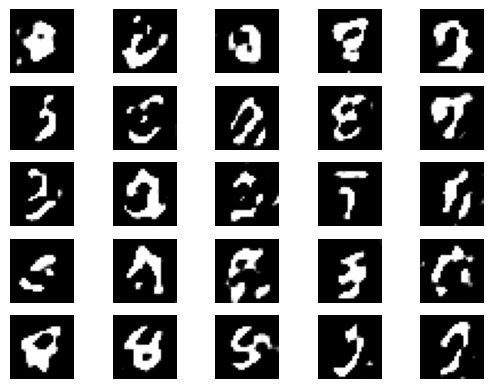

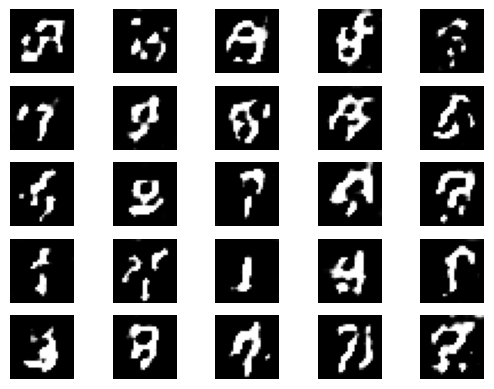

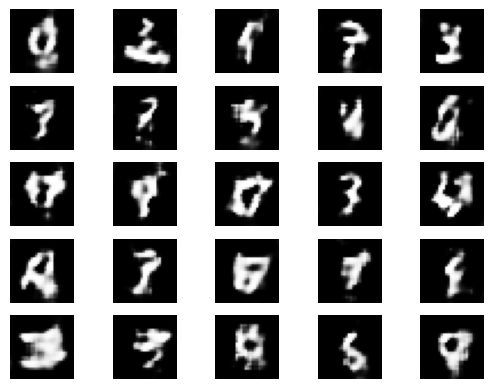

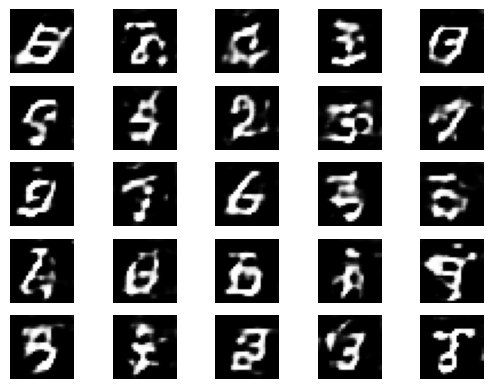

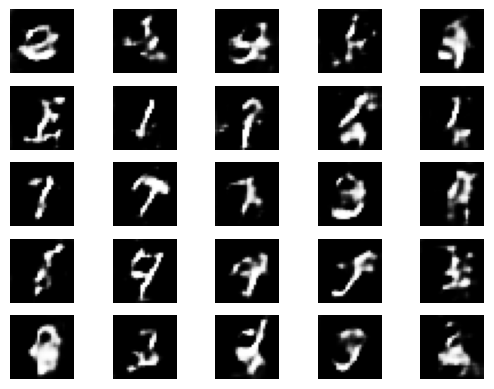

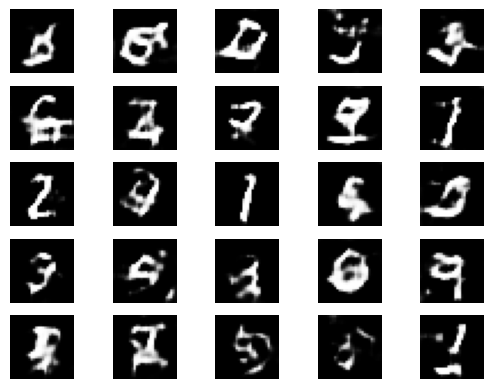

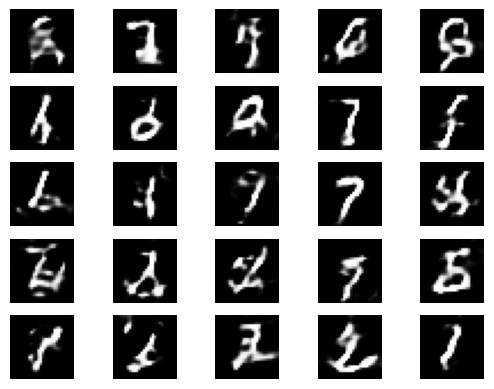

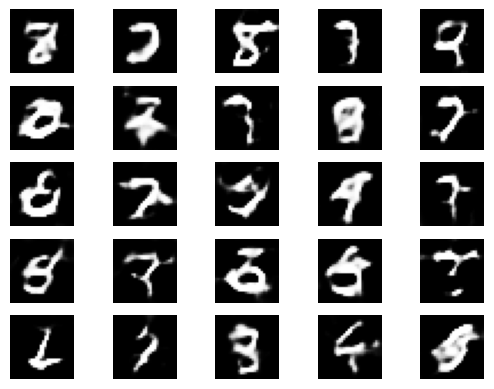

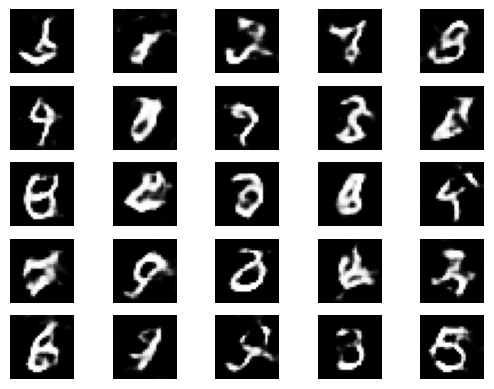

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 이 장의 주요 내용과 관련이 없어 
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장되게 하였습니다.


## 4. 이미지의 특징을 추출하는 오토인코더

### 실습: 오토인코더 실습하기

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터셋을 불러옵니다.

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델을 만듭니다.
autoencoder = Sequential()

# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분입니다.
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인합니다.
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 4, 4, 8)           584       
                                                                 
 conv2d_21 (Conv2D)          (None, 4, 4, 8)          

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
463/469 [============================>.] - ETA: 0s - loss: 0.0861WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000012BC0C77708> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the fu

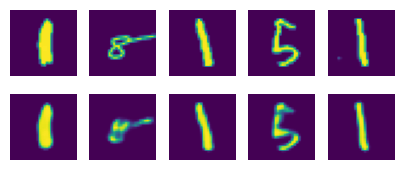

In [7]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)                     # 앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):        # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1)
   plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()